# Fast Methods of Approximating Quadratically-Regularized Optimal Transport

### Austin Du's Math Honors Thesis <br> Advised by: Professor Alex Cloninger

In [1]:
from OT_functions import *
import scipy.stats as stats
import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
def draw_graph(G, color):
    plt.cla()
    nx.drawing.nx_pylab.draw_networkx(G, pos = nx.get_node_attributes(G,'pos'), 
                                      with_labels = False, node_size = 20, linewidths = 0.5, 
                                      node_color = color, edge_color = 'grey')

    return G

## What is Optimal Transport on a Graph?

* Start with a point cloud of nodes. Create a sample of 500 points on $[0,1]^2$ with varied distributions.
* We will eventually place source/sink mass distributions on these nodes.

In [3]:
def uniform_X(n = 500, d = 2):
    return np.random.uniform(0, 1, d*n).reshape(n, d)

def skewed_X(a, b, n = 500, d = 2):
    return stats.beta.rvs(a, b, size = d*n).reshape(n, d)
    
def in_range(point, center, r):
    arr_point = np.array(point)
    arr_center = np.array(center)
    return np.linalg.norm(arr_point - arr_center) < r

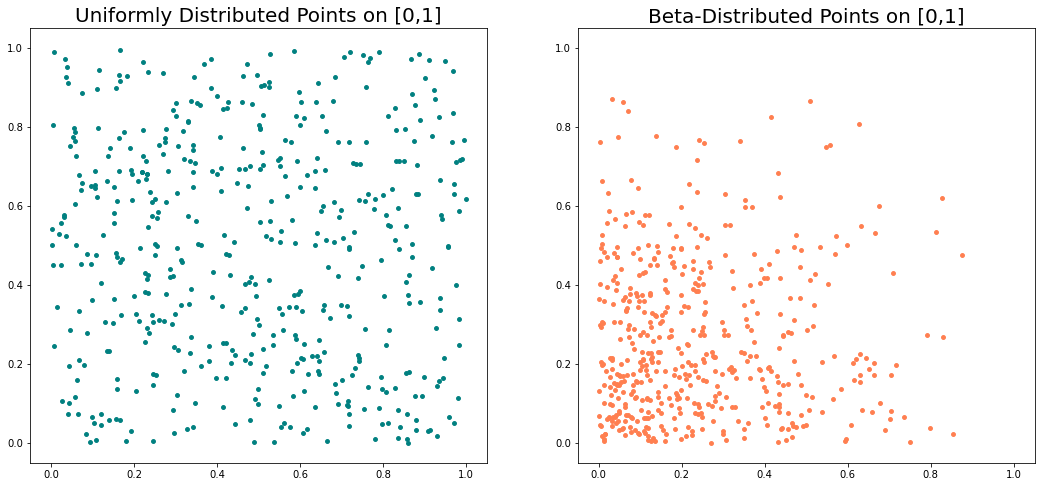

In [4]:
fig, axs = plt.subplots(1, 2, figsize = (18,8))
axs[0].set_title('Uniformly Distributed Points on [0,1]', size = 20)
axs[1].set_title('Beta-Distributed Points on [0,1]',  size = 20)

X1 = uniform_X()
nbrs = get_k_neighbors(X1, 3)

plt.sca(axs[0])
plt.scatter(X1[:,0], X1[:,1], color = 'teal', s = 15)
plt.xlim(-.05,1.05)
plt.ylim(-.05,1.05)

X2 = skewed_X(1, 3)
nbrs = get_k_neighbors(X2, 3)
plt.sca(axs[1])
plt.scatter(X2[:,0], X2[:,1], color = 'coral', s = 15)
plt.xlim(-.05,1.05)
plt.ylim(-.05,1.05)

plt.show()

## Connect densely with k-Nearest-Neighbors

* Use sklearn's k-Nearest-Neighbors Algorithm to connect each point to its k nearest points.
* This is the traditional method.

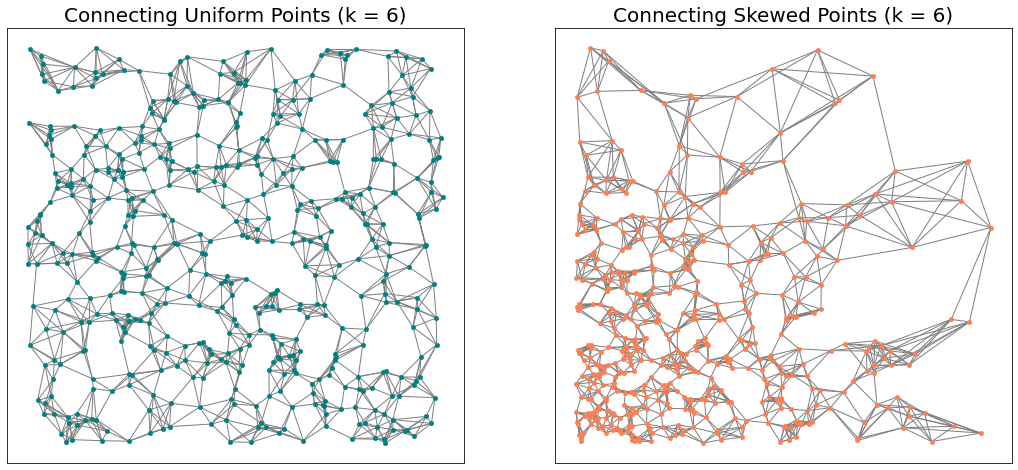

In [5]:
fig, axs = plt.subplots(1, 2, figsize = (18,8))

nearest_nbrs1 = get_k_neighbors(X1, 6)
nearest_nbrs2 = get_k_neighbors(X2, 6)

plt.sca(axs[0])
G5 = create_graph(X1, nearest_nbrs1)
draw_graph(G5, 'teal')
# plt.text(0.7, .85, 'n_edges = {}'.format(G5.number_of_edges()), style='italic', size = 12,
#                  bbox={'facecolor': 'pink', 'alpha': 0.5, 'pad': 10})
plt.title('Connecting Uniform Points (k = 6)',  size = 20)

plt.sca(axs[1])
G6 = create_graph(X2, nearest_nbrs2)
draw_graph(G6, 'coral')
# plt.text(.63, .76, 'n_edges = {}'.format(G6.number_of_edges()), style='italic', size = 12,
#                  bbox={'facecolor': 'pink', 'alpha': 0.5, 'pad': 10})
plt.title('Connecting Skewed Points (k = 6)', size = 20)

plt.show()

Note many of these edges seem unnecessary for a transport across the graph.

In [6]:
def draw_digraph(G):

    # set colors and sizes for nodes
    source_color = '#FFBC38'   #orange
    sink_color = '#5D92F3'     #blue
    zero_color = '#B1B1B1'     #gray
    
    # classify whether nodes are sources, sinks, or neither
    is_source = np.array(list(nx.get_node_attributes(G,'is_source').values()))
    node_colors = np.where(is_source > 0, source_color, np.where(is_source == 0, zero_color, sink_color))
    
    node_sizes = 400*(np.abs(is_source)) + 10
    
    # get positions of nodes from node attributes
    pos = nx.get_node_attributes(G,'pos')

    # set colors (opacity) for edges
    edge_colors = [(.5,.5,.5,min(1,np.sqrt(G[u][v]['weight']))) for u,v in G.edges()]
    
    # draw graph
    nx.drawing.nx_pylab.draw_networkx(G, pos, with_labels = False, arrows = True, 
                                      arrowsize = 10, arrowstyle = '->', edge_color = edge_colors, 
                                      node_color = node_colors, 
                                      width = 2, 
                                      node_size = node_sizes)

    # display warning if graph was not connected
    if len(G.edges()) == 0:
        plt.text(.3, .5, 'graph was not connected', style='italic',
                 bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 10})

    return G


## Place the source and sink distributions and draw the optimal paths from source to sink

* Many paths are possible, but the chosen one will minimize some objective function
* Lots of objective functions exist, but the one I worked with is "quadratically-regularized" 

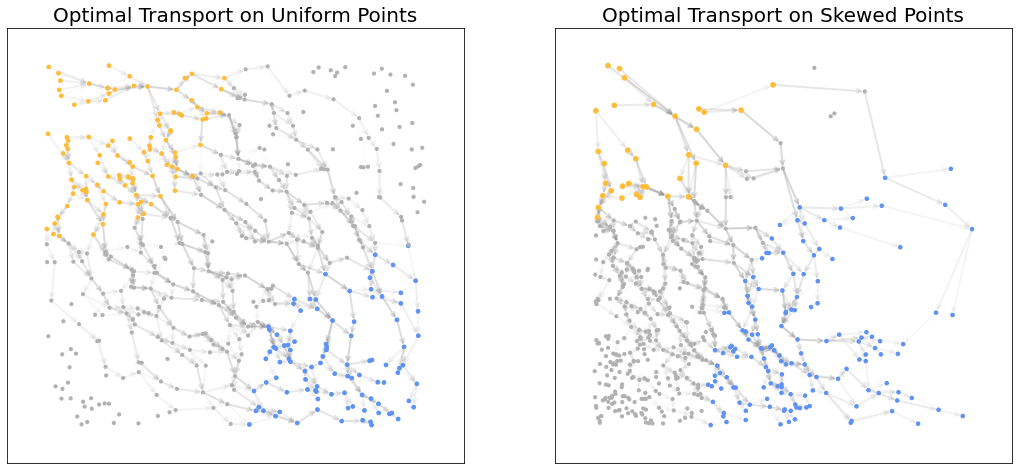

In [10]:
fig, axs = plt.subplots(1, 2, figsize = (18,8))

X1_pmf = make_uniform_pmf(X1, (0,1), (1,0))
X2_pmf = make_uniform_pmf(X2, (0,1), (1,0), r_sink = .75)

plt.sca(axs[0])
dg1 = create_reg_digraph(X1, nearest_nbrs1, X1_pmf, alpha = .3)[0]
draw_digraph(dg1)
# plt.text(.7, .85, 'M(G) = {}'.format(np.round(get_M(dg1), 4)), style='italic', size = 12,
#                  bbox={'facecolor': 'pink', 'alpha': 0.5, 'pad': 10})
plt.title('Optimal Transport on Uniform Points', size = 20)

plt.sca(axs[1])
dg2 = create_reg_digraph(X2, nearest_nbrs2, X2_pmf, alpha = .3)[0]
draw_digraph(dg2)
# plt.text(.63, .76, 'M(G) = {}'.format(np.round(get_M(dg2), 4)), style='italic', size = 12,
#                  bbox={'facecolor': 'pink', 'alpha': 0.5, 'pad': 10})
plt.title('Optimal Transport on Skewed Points', size = 20)

plt.show()

## Proper definition of QR Optimal Transport

* The goal is a weight vector $\mathbf{w} \in \mathbb{R}^{|E|}$.
* Consider a length vector $\mathbf{l} \in \mathbb{R}^{|E|}$.
* Let $\alpha$ be a constant greater than 0 (the "tuning parameter").
* Then the optimal $\mathbf{w}$ minimizes the QR Wasserstein Distance:

$$\mathcal{W}(G, \mathbf{f}, \alpha) = \begin{cases}  
\min_{\mathbf{w}\in\mathbb{R}^{|E|}} & \sum_{e\in E} w_el_e +  \frac{\alpha}{2} \sum_{e \in E} w_e^2 \\
\text{  s.t.} & \mathbf{w} \text{ has in-flow and out-flow equal at each}\\ & \text{node, except at sources and sinks}
\end{cases}$$

* We can formalize the wordy Kirchhoff Law using the incidence matrix $D \in \mathbb{R}^{|V| \times |E|}$. In each of the $|V|$ rows of $D$, there is a $1$ if the respective edge flows into the vertex, a $-1$ if it flows out, and $0$ otherwise.
* We can then minimize $$\mathcal{W}(G, \mathbf{f}, \alpha) = \begin{cases}  
\min_{\mathbf{w}\in\mathbb{R}^{|E|}} & \sum_{e\in E} w_el_e +  \frac{\alpha}{2} \sum_{e \in E} w_e^2 \\
\text{  s.t.} & D\mathbf{w} = f \\
& \mathbf{w} \geq 0
\end{cases}$$where $f = [\text{sink distribution}] - [\text{source distribution}]$ classifies whether a node is a source, sink, or neither. 


* This is now solvable via any Quadratic Programming solver.
    * Very vulnerable to large matrices

## Approximating QR Wasserstein Distance with Sparser Connections

* Devised in a paper by Linderman, Mishne, Jaffe, Kluger, and Steinerberger [2], we can connect nodes by considering many neighbors for each node, but only connecting the neighbor with a certain uniform probability.
    - Look at the $K$ nearest points around you and expect to connect to only $k$ of them.
    - Connectivity properties were proven when $K \propto \log|V|$ and $k \propto \log \log |V|$.
    

* This is called the k-of-K Near Neighbors method and creates much sparser graphs.
    * Drawback: Leaves small, unconnected components

## A Better Solution: The Partition Method

* Recommended in [2] but not proven, partition the points into $K/k$ groups, and connect each node to its $k$ nearest neighbors within each group.
    * This both maintains connectivity, and requires less operating time.

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (18,8))

nearest_nbrs1 = get_k_neighbors(X1, 6)
nearest_nbrs2 = get_k_neighbors(X2, 6)

plt.sca(axs[0])
G5 = create_graph(X1, nearest_nbrs1)
draw_graph(G5, 'teal')
plt.text(0.7, .85, 'n_edges = {}'.format(G5.number_of_edges()), style='italic', size = 12,
                 bbox={'facecolor': 'pink', 'alpha': 0.5, 'pad': 10})
plt.title('K-connecting Uniform Points (k = 6)',  size = 20)

plt.sca(axs[1])
G6 = create_graph(X2, nearest_nbrs2)
draw_graph(G6, 'coral')
plt.text(0.65, .8, 'n_edges = {}'.format(G6.number_of_edges()), style='italic', size = 12,
                 bbox={'facecolor': 'pink', 'alpha': 0.5, 'pad': 10})
plt.title('K-connecting Skewed Points (k = 6)', size = 20)

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (18,8))

partitioned_nbrs1 = get_k_partitioned_neighbors(X1, 2, 3)
partitioned_nbrs2 = get_k_partitioned_neighbors(X2, 2, 3)

plt.sca(axs[0])
G3 = create_graph(X1, partitioned_nbrs1)
draw_graph(G3, 'teal')
plt.text(.7, .85, 'n_edges = {}'.format(G3.number_of_edges()), style='italic', size = 12,
                 bbox={'facecolor': 'pink', 'alpha': 0.5, 'pad': 10})
plt.title('Partition-connecting Uniform Points (k/K = 2/6)', size = 20)

plt.sca(axs[1])
G4 = create_graph(X2, partitioned_nbrs2)
draw_graph(G4, 'coral')
plt.text(.65, .8, 'n_edges = {}'.format(G4.number_of_edges()), style='italic', size = 12,
                 bbox={'facecolor': 'pink', 'alpha': 0.5, 'pad': 10})
plt.title('Partition-connecting Skewed Points (k/K = 2/6)', size = 20)

plt.show()

In [2]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('rise', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})

{'width': 1024, 'height': 768, 'scroll': True}

## Use the Partition Graph to Estimate Results on Nearest Graph

#### Performed simulations on these 4 types of graphs:
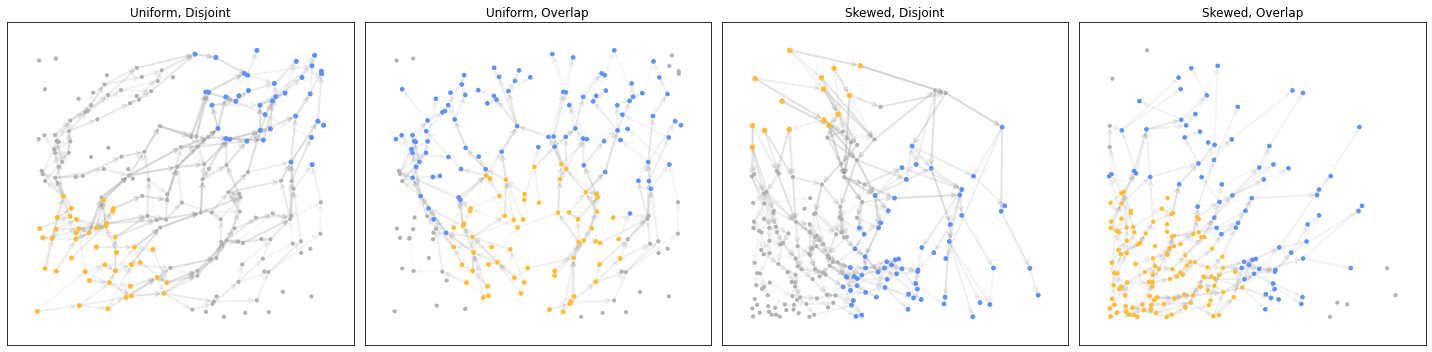

#### Comparison Between True Wasserstein Distance and the Partition-based Estimate

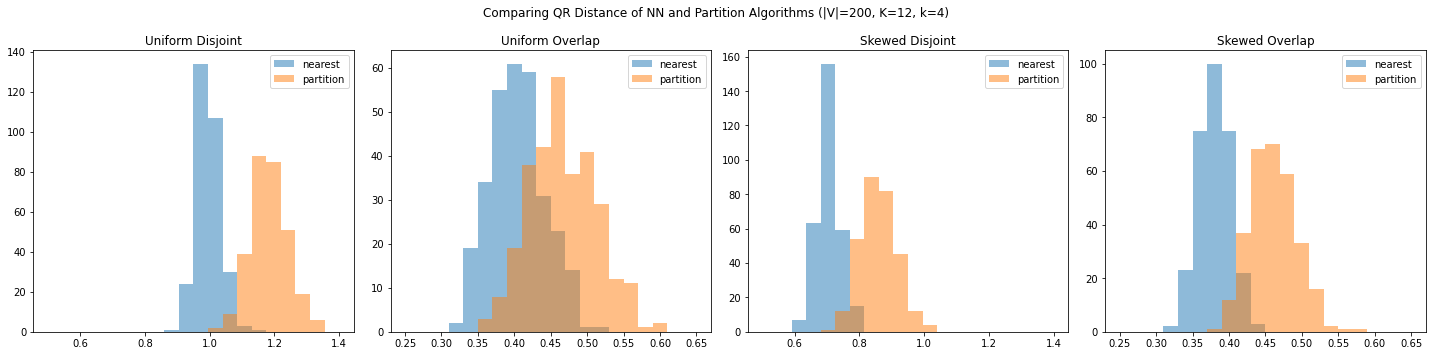

#### Comparing Ratios

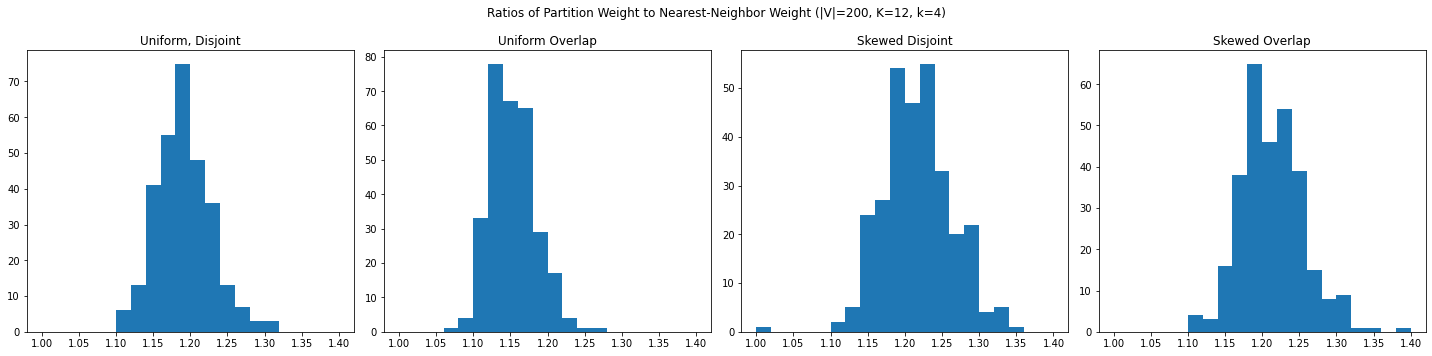

* Empirically, we see the estimated distributions producing a value around 1.15 - 1.20 times the original value. 
* Suggests that we can perform a cheaper calculation on the Partition-graph and then scale down for an unbiased estimation.

#### Comparing Runtimes

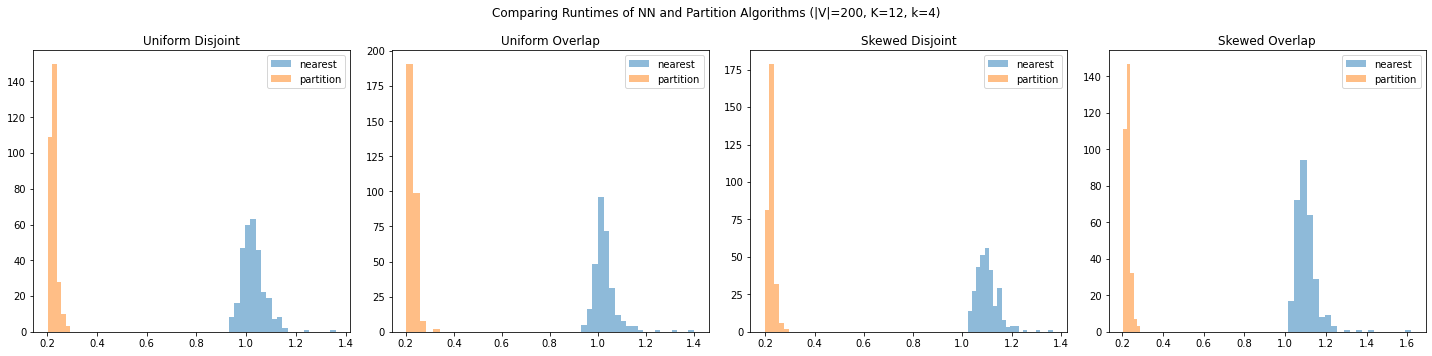

* Calculating QR Wasserstein distance on a Partition-graph operates around an order of magnitude faster than on a k-connected graph.

## An Issue with Sparsifying

* The tuning factor $\alpha$ controls the impact of the regularizer, and in turn the sparsity of the optimal transport.
* Since the partition graph is sparser, we perform an $\alpha$-scaling before calculating QR Wasserstein distance.
* Goal: Find an $\alpha$-scaling that makes the regularizer term approximately equal in the OT on both the nearest graph and the partition graph.

## Finding Optimal $\alpha$ scaling

* We perform simulations with $\alpha$-scaling of 0.2, 0.4, and 0.6.
* When changing node count, mass distribution, or initial $\alpha$, while fixing $k/K = 4/12$, the optimal $\alpha$-scaling exhibits little to no change: a scaling of around 0.4 is optimal.

<p align="center">
    <img src="changing_nothing.png" alt="drawing" width="700"/>
    <img src="changing_num_nodes.png" alt="drawing" width="700"/>
    <img src="changing_alpha_4.png" alt="drawing" width="700"/>
    <img src="changing_alpha_2.png" alt="drawing" width="700"/>
    <img src="changing_points.png" alt="drawing" width="700"/>
</p>



* We only see large changes when $k/K$ is changed
    * Need more scaling when $k/K$ is near 0 (heavy sparsification)
    * Need less scaling when $k/K$ is near 1 (light sparsification)
* This suggests that we can find a proper scaling as a function of $(k,K)$, but more research needs to be done on this topic.

<p align="center">
    <img src="changing_k_2.png" alt="drawing" width="700"/>
    <img src="changing_k_3.png" alt="drawing" width="700"/>
    <img src="changing_k_4.png" alt="drawing" width="700"/>
    <img src="changing_k_6.png" alt="drawing" width="700"/>
    <img src="changing_K_8.png" alt="drawing" width="700"/>
</p>

## Approximation by Geometry

Notice the following:
* Since we are assuming our graphs to be bidirectional, we can use just one arbitrary direction and allow $\mathbf{w}$ to take negative values.
* Our optimization problem then becomes $$\mathcal{W}(G, \mathbf{f}, \alpha) = \begin{cases}  
\min_{\mathbf{w}\in\mathbb{R}^{|E|}} & \sum_{e\in E} |w_e|l_e +  \frac{\alpha}{2} \sum_{e \in E} w_e^2 \\
\text{  s.t.} & D\mathbf{w} = f
\end{cases}$$

Let the objective function equal a value $x$ that we're trying to minimize. Then we perform the following simplification:
\begin{align*}
    |\mathbf{w}| \cdot \mathbf{l} + \frac{\alpha}{2} |\mathbf{w}| \cdot |\mathbf{w}| &= x \\
    |\mathbf{w}| \cdot |\mathbf{w}| + \frac{2}{\alpha}|\mathbf{w}| \cdot \mathbf{l} + \frac{1}{\alpha^2} \mathbf{l} \cdot \mathbf{l} &= \frac{2x}{\alpha} + \frac{1}{\alpha^2} \mathbf{l} \cdot \mathbf{l} \\
    \left( |\mathbf{w}| + \frac{\mathbf{l}}{\alpha} \right) \cdot \left( |\mathbf{w}| + \frac{\mathbf{l}}{\alpha} \right) &= \frac{2x}{\alpha} + \frac{\lVert\mathbf{l}\rVert^2}{\alpha^2} \\
    \left\lVert |\mathbf{w}| + \frac{\mathbf{l}}{\alpha} \right\rVert &= \sqrt{\frac{2x}{\alpha} + \frac{\lVert\mathbf{l}\rVert^2}{\alpha^2}}
\end{align*}
We now minimize $r = \sqrt{\frac{2x}{\alpha} + \frac{\lVert\mathbf{l}\rVert^2}{\alpha^2}}$.

* Considering level sets of $\left\lVert |\mathbf{w}| + \frac{\mathbf{l}}{\alpha} \right\rVert = r$, we get growing "footballs" around the origin (working title).

<p align="center">
    <img src="football.png" alt="drawing" width="700"/>
</p>

* Minimizing $r$ becomes finding the first intersection between the footballs and $S$, the affine solution space of $D\mathbf{w} = f$.

* Hasty idea: 
    * This is just a projection of $-\frac{\mathbf{l}}{\alpha}$ onto $S$ that has some zero values.
    * Find components that must be zero 
    * Fix zero components and project non-zero components
    
    
* This almost works

The previous idea fails in higher dimensions:
<p align="center">
    <img src="football_counterexample.png" alt="drawing" width="820"/>
</p>

#### Comparing True QR OT weights vs. Football Algorithm's weights
<p align = "right">
   <img src="football_vs_true.png" alt="drawing" width="820"/>
</p>

* The algorithm is a good approximation for a high-dimensional vector that is *very* fast
    * Only requires 3 sparse least-squares calculations
* If an exact solution is desired, it is a great, inexpensive initialization for Quadratic Programming

## Conclusion

* Two methods for approximating QR Wasserstein distance
    * Partition Algorithm
        * Calculates distance on sparser graphs and then scales accordingly
    * Football Algorithm
        * Exploits geometry and sparsity of the quadratic program

## Ackowledgements

Immense thanks to Professor Cloninger for his invaluable direction and guidance along the way.

## Papers Cited

[1] Quadratically-Regularized Optimal Transport on Graphs; Montacer Essid, Justin Solomon; https://arxiv.org/abs/1704.08200
[2] Randomized Near Neighbor Graphs, Giant Components, and Applications in Data Science; George C. Linderman, Gal Mishne, Yuval Kluger, Stefan Steinerberger; https://arxiv.org/abs/1711.04712